[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/homography.ipynb)

# Image Alignment by Homography Optimization

In this tutorial we are going to learn how to perform the task of image alignment by optimising the homography transformation between two images.

In [ ]:
%%capture
!pip install kornia

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


download_image("https://github.com/kornia/data/raw/main/homography/H1to2p")
download_image("https://github.com/kornia/data/raw/main/homography/img1.ppm")
download_image("https://github.com/kornia/data/raw/main/homography/img2.ppm")

'img2.ppm'

Import needed libraries

In [ ]:
import os
from typing import List

import cv2
import kornia as K
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from kornia.geometry import resize

# computer vision libs :D

Define the hyper parameters to perform the online optimisation

In [ ]:
learning_rate: float = 1e-3  # the gradient optimisation update step
num_iterations: int = 100  # the number of iterations until convergence
num_levels: int = 6  # the total number of image pyramid levels
error_tol: float = 1e-8  # the optimisation error tolerance

log_interval: int = 100  # print log every N iterations
use_cuda: bool = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Using ", device)

Using  cuda


In [ ]:
def load_image(file_name: str) -> torch.Tensor:
    """Loads the image with OpenCV and converts to torch.Tensor"""
    assert os.path.isfile(file_name), f"Invalid file {file_name}"

    # load image with OpenCV
    img: np.ndarray = cv2.imread(file_name, cv2.IMREAD_COLOR)

    # convert image to torch tensor
    tensor: torch.Tensor = K.utils.image_to_tensor(img).float() / 255.0  # CxHxW
    return tensor[None]  # 1xCxHxW

Define a container to hold the homography as a `nn.Parameter` so that cen be used by the autograd within the `torch.optim` framework.

We initialize the homography with the identity transformation.

In [ ]:
class MyHomography(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.homography = nn.Parameter(torch.Tensor(3, 3))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.eye_(self.homography)

    def forward(self) -> torch.Tensor:
        return torch.unsqueeze(self.homography, dim=0)  # 1x3x3

Read the images and the ground truth homograpy to convert to tensor. In addition, we normalize the homography in order to smooth the gradiens during the optimisation process.

In [ ]:
img_src: torch.Tensor = load_image("img1.ppm").to(device)
img_dst: torch.Tensor = load_image("img2.ppm").to(device)
print(img_src.shape)
print(img_dst.shape)

dst_homo_src_gt = np.loadtxt("H1to2p")
dst_homo_src_gt = torch.from_numpy(dst_homo_src_gt)[None].float().to(device)
print(dst_homo_src_gt.shape)
print(dst_homo_src_gt)

height, width = img_src.shape[-2:]

# warp image in normalized coordinates
normal_transform_pixel: torch.Tensor = K.geometry.normal_transform_pixel(height, width, device=device)

dst_homo_src_gt_norm: torch.Tensor = normal_transform_pixel @ dst_homo_src_gt @ torch.inverse(normal_transform_pixel)

img_src_to_dst_gt: torch.Tensor = K.geometry.homography_warp(img_src, torch.inverse(dst_homo_src_gt_norm), (height, width))

img_src_vis: np.ndarray = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_src))
img_dst_vis: np.ndarray = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_dst))
img_src_to_dst_gt_vis: np.ndarray = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_src_to_dst_gt))

torch.Size([1, 3, 640, 800])
torch.Size([1, 3, 640, 800])
torch.Size([1, 3, 3])
tensor([[[ 8.7977e-01,  3.1245e-01, -3.9431e+01],
         [-1.8389e-01,  9.3847e-01,  1.5316e+02],
         [ 1.9641e-04, -1.6015e-05,  1.0000e+00]]], device='cuda:0')


Show the source image, the target and the source image warped to the target using the ground truth homography transformation.

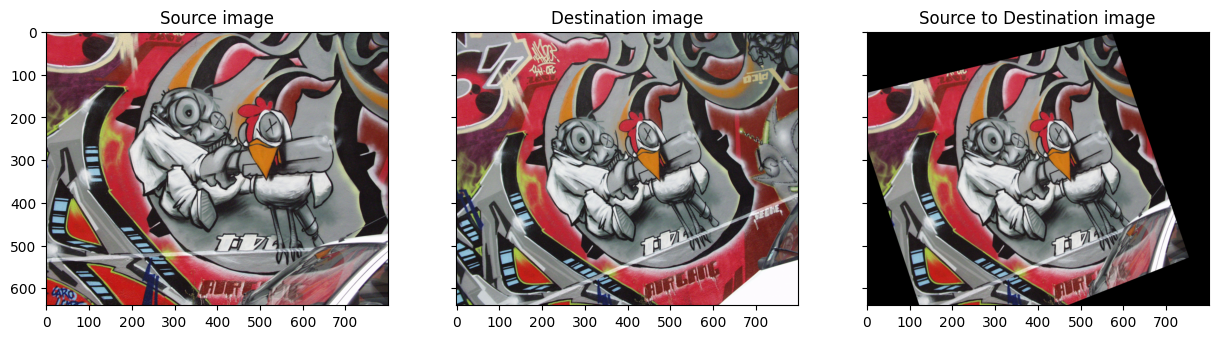

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)

ax1.imshow(img_src_vis)
ax1.set_title("Source image")

ax2.imshow(img_dst_vis)
ax2.set_title("Destination image")

ax3.imshow(img_src_to_dst_gt_vis)
ax3.set_title("Source to Destination image")
plt.show()

Initialize the homography warper and pass the parameters to the `torch.optim.Adam` optimizer to perform an online gradient descent optimisation to approximate the mapping transformation between the two images.

In [ ]:
# create homography parameters
dst_homo_src = MyHomography().to(device)

# create optimizer
optimizer = optim.Adam(dst_homo_src.parameters(), lr=learning_rate)

# send data to device
img_src, img_dst = img_src.to(device), img_dst.to(device)

In order to perform the online optimisation, we will apply a know fine-to-coarse strategy. For this reason, we precompute a gaussian pyramid from each image with a certain number of levels.

In [ ]:
### compute Gaussian Pyramid


def get_gaussian_pyramid(img: torch.Tensor, num_levels: int) -> List[torch.Tensor]:
    r"""Utility function to compute a gaussian pyramid."""
    pyramid = []
    pyramid.append(img)
    for _ in range(num_levels - 1):
        img_curr = pyramid[-1]
        img_down = K.geometry.pyrdown(img_curr)
        pyramid.append(img_down)
    return pyramid


# compute the gaussian pyramids
img_src_pyr: List[torch.Tensor] = get_gaussian_pyramid(img_src, num_levels)
img_dst_pyr: List[torch.Tensor] = get_gaussian_pyramid(img_dst, num_levels)

## Main optimization loop

Define the loss function to minimize the photometric error at each pyramid level:

 $ L = \sum |I_{ref} - \omega(I_{dst}, H_{ref}^{dst}))|$

In [ ]:
def compute_scale_loss(
    img_src: torch.Tensor,
    img_dst: torch.Tensor,
    dst_homo_src: nn.Module,
    optimizer: torch.optim,
    num_iterations: int,
    error_tol: float,
) -> torch.Tensor:
    assert len(img_src.shape) == len(img_dst.shape), (img_src.shape, img_dst.shape)

    # init loop parameters
    loss_tol = torch.tensor(error_tol)
    loss_prev = torch.finfo(img_src.dtype).max

    for i in range(num_iterations):
        # create homography warper
        src_homo_dst: torch.Tensor = torch.inverse(dst_homo_src)

        _height, _width = img_src.shape[-2:]
        warper = K.geometry.HomographyWarper(_height, _width)
        img_src_to_dst = warper(img_src, src_homo_dst)

        # compute and mask loss
        loss = F.l1_loss(img_src_to_dst, img_dst, reduction="none")  # 1x3xHxW

        ones = warper(torch.ones_like(img_src), src_homo_dst)
        loss = loss.masked_select(ones > 0.9).mean()

        # compute gradient and update optimizer parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Run the main body loop to warp the images from each pyramid level and evaluate the loss to perform gradient update.

Optimization iteration: 0/6
Reprojection error: 0.17220820486545563


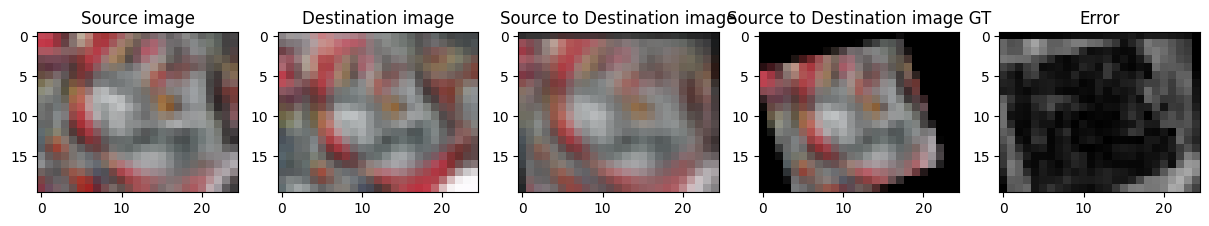

Optimization iteration: 1/6
Reprojection error: 0.11616469919681549


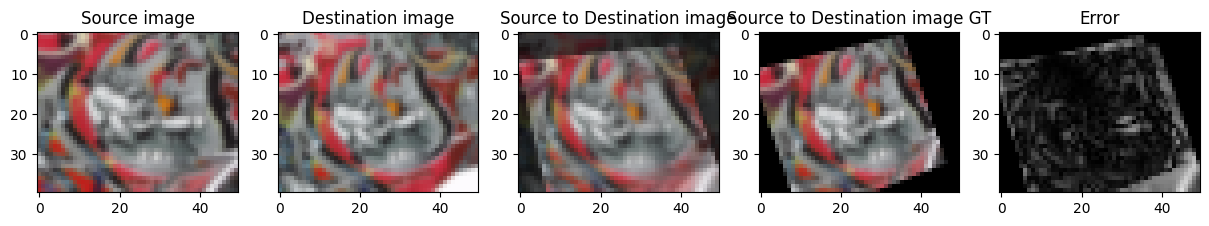

Optimization iteration: 2/6
Reprojection error: 0.01828487403690815


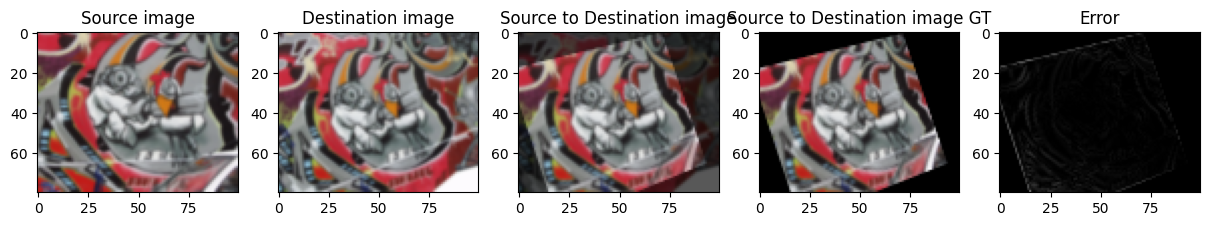

Optimization iteration: 3/6
Reprojection error: 0.0132159274071455


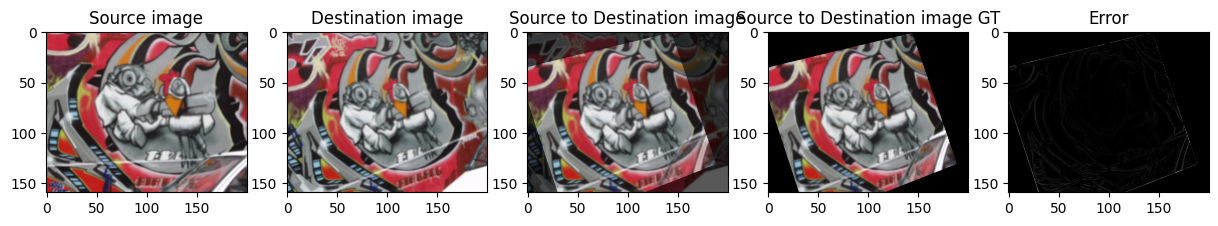

Optimization iteration: 4/6
Reprojection error: 0.008075939491391182


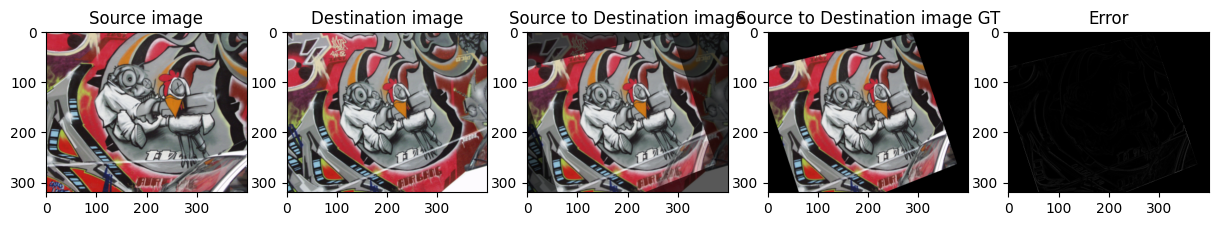

Optimization iteration: 5/6
Reprojection error: 0.0053129130974411964


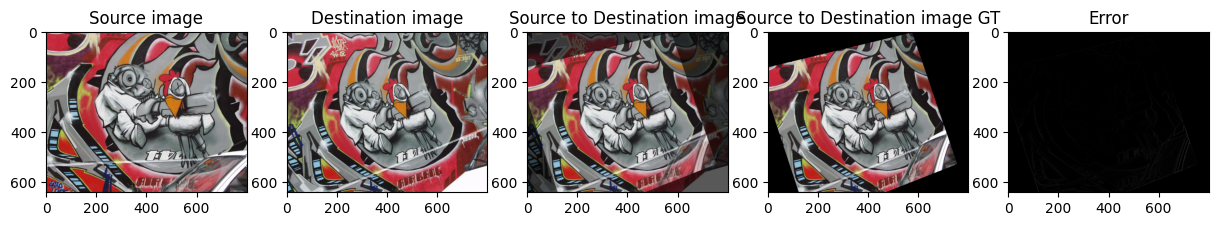

In [ ]:
# pyramid loop

for iter_idx in range(num_levels):
    # get current pyramid data
    scale: int = (num_levels - 1) - iter_idx
    img_src = img_src_pyr[scale]
    img_dst = img_dst_pyr[scale]

    # compute scale loss
    compute_scale_loss(img_src, img_dst, dst_homo_src(), optimizer, num_iterations, error_tol)

    print(f"Optimization iteration: {iter_idx}/{num_levels}")

    # merge warped and target image for visualization
    h, w = img_src.shape[-2:]
    warper = K.geometry.HomographyWarper(h, w)
    img_src_to_dst = warper(img_src, torch.inverse(dst_homo_src()))
    img_src_to_dst_gt = warper(img_src, torch.inverse(dst_homo_src_gt_norm))

    # compute the reprojection error
    error = F.l1_loss(img_src_to_dst, img_src_to_dst_gt, reduction="none")
    print(f"Reprojection error: {error.mean()}")

    # show data
    img_src_vis = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_src))
    img_dst_vis = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_dst))
    img_src_to_dst_merge = 0.65 * img_src_to_dst + 0.35 * img_dst
    img_src_to_dst_vis = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_src_to_dst_merge))
    img_src_to_dst_gt_vis = K.utils.tensor_to_image(K.color.bgr_to_rgb(img_src_to_dst_gt))

    error_sum = error.mean(dim=1, keepdim=True)
    error_vis = K.utils.tensor_to_image(error_sum)

    # show the original images at each scale level, the result of warping using
    # the homography at moment, and the estimated error against the GT homography.

    %matplotlib inline
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, sharey=False)
    fig.set_figheight(15)
    fig.set_figwidth(15)

    ax1.imshow(img_src_vis)
    ax1.set_title("Source image")

    ax2.imshow(img_dst_vis)
    ax2.set_title("Destination image")

    ax3.imshow(img_src_to_dst_vis)
    ax3.set_title("Source to Destination image")

    ax4.imshow(img_src_to_dst_gt_vis)
    ax4.set_title("Source to Destination image GT")

    ax5.imshow(error_vis, cmap="gray", vmin=0, vmax=1)
    ax5.set_title("Error")
    plt.show()